# Transfer learning

[Transfer learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) is a powerful technique that allows sophisticated convolutional neural networks (CNNs) trained by Google, Microsoft, and others on high-performance computing (HPC) clusters equipped with GPUs to be repurposed and used to solve domain-specific problems. With transfer learning, for example, you can take a CNN trained to distinguish between dogs and cats and modify it to distinguish between hot dogs and hambugers. And you can do it on a laptop computer — no GPU required.

Many pretrained CNNs are available in the public domain, and several are included with Keras. In this exercise, you will use Keras and Microsoft's [ResNet50V2](https://keras.io/api/applications/resnet/#resnet50v2-function) pretrained CNN to build a network that distinguishes with a high degree of accuracy between images containing hot dogs, pizza, and sushi.

![](Images/food.png)

## Create an image pipeline

The first step is to use Keras's [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) class to create a pipeline for loading images. We will create two image pipelines: one for training images and one for test images. Because images input to `ResNet50V2` must be preprocessed by Keras's `keras.applications.resnet50.preprocess_input` function, we will configure `ImageDataGenerator` to use that function. We will also disable image shuffling so we can recreate the labels that go with the images later on.

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

image_batch_size = 10
idg = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

train_generator = idg.flow_from_directory(
    directory='food/train',
    target_size=(224, 224),
    batch_size=image_batch_size,
    class_mode='categorical',
    shuffle=False, # Prevent shuffling so labels can be recreated
    seed=42
)

test_generator = idg.flow_from_directory(
    directory='food/test',
    target_size=(224, 224),
    batch_size=image_batch_size,
    class_mode='categorical',
    shuffle=False, # Prevent shuffling so labels can be recreated
    seed=42
)

Found 60 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


use `ImageDataGenerator`'s `class_indices` property to show classes and labels.

In [2]:
class_indices = train_generator.class_indices
print(class_indices)

{'hotdog': 0, 'pizza': 1, 'sushi': 2}


Define a function for converting a one-hot-encoded class value into the corresponding label.

In [3]:
def get_label(y, indices):
    return list(indices.keys())[list(indices.values()).index(y.argmax(axis=-1))]

In order to visualize the data, use Matplotlib to plot the first eight training images. The images look different than before because the `preprocess_input` function converts them from RGB format to BGR, but they are still recognizable as food images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


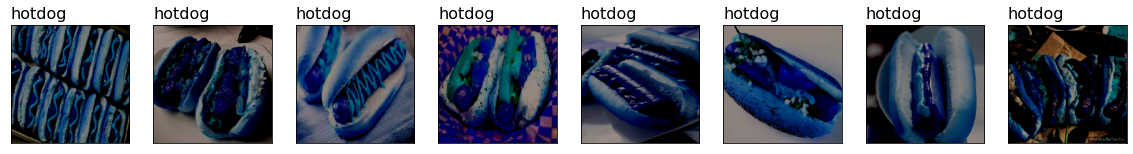

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

images = train_generator[0][0] # First 10 images
labels = train_generator[0][1] # First 10 labels

fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.text(0.0, 1.05, get_label(labels[i], class_indices), transform=ax.transAxes, fontsize=16)
    
train_generator.reset()

Now let's do the same for the first eight test images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


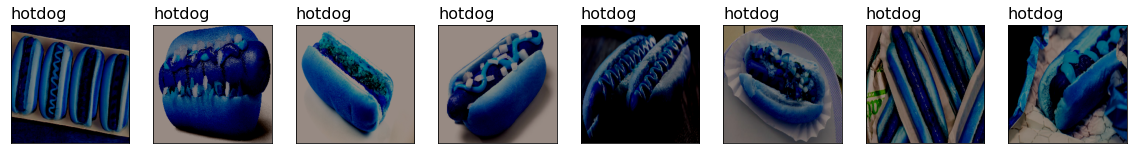

In [5]:
images = test_generator[0][0] # First 10 images
labels = test_generator[0][1] # First 10 labels

fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.text(0.0, 1.05, get_label(labels[i], class_indices), transform=ax.transAxes, fontsize=16)
    
test_generator.reset()

## Use ResNet50V2 to extract features from images

Rather than create a CNN of our own, we will load `ResNet50V2` minus the classification layers and initialize it with the weights arrived at when it was trained on the [ImageNet](http://www.image-net.org/) dataset. We will then run our training and test images through it to extract features from them. The code that generates the labels assumes that the images are served up in the same order every time they're fetched, which is why we set `shuffle` to `False` when we called `flow_from_directory`.

In [6]:
from tensorflow.keras.applications import ResNet50V2

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

train_x = base_model.predict(train_generator)
test_x = base_model.predict(test_generator)

train_generator.reset()
test_generator.reset()

Now generate a set of labels to go with the features extracted from the training and test images.

In [7]:
import numpy as np

train_y = []
iterations = train_generator.samples // image_batch_size

for i in range(iterations):
    train_y.extend(np.array(train_generator[i][1]))

train_y = np.array(train_y)

test_y = []
iterations = test_generator.samples // image_batch_size

for i in range(iterations):
    test_y.extend(np.array(test_generator[i][1]))
    
test_y = np.array(test_y)

train_generator.reset()
test_generator.reset()

## Train a network with the output from ResNet50V2

Now that we've used `ResNet50V2` to process hot-dog, pizza, and sushi images, it's a simple matter to replace that network's classification layers with classification layers of our own and train them with the output. Once more, we'll use a modest amount of dropout in hopes that the network will generalize better.

In [8]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(Flatten(input_shape=train_x.shape[1:]))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(train_x, train_y, epochs=20, batch_size=5, validation_data=(test_x, test_y))

Epoch 1/20
12/12 [==============================] - 8s 56ms/step - loss: 6.3009 - accuracy: 0.4975 - val_loss: 1.3295 - val_accuracy: 0.8667
Epoch 2/20
12/12 [==============================] - 0s 30ms/step - loss: 6.0470 - accuracy: 0.8295 - val_loss: 0.5356 - val_accuracy: 0.9333
Epoch 3/20
12/12 [==============================] - 0s 30ms/step - loss: 0.1707 - accuracy: 0.9770 - val_loss: 1.3218 - val_accuracy: 0.9333
Epoch 4/20
12/12 [==============================] - 0s 30ms/step - loss: 0.0358 - accuracy: 0.9928 - val_loss: 1.2984 - val_accuracy: 0.9333
Epoch 5/20
12/12 [==============================] - 0s 30ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.3453 - val_accuracy: 0.9333
Epoch 6/20
12/12 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.2456 - val_accuracy: 0.9333
Epoch 7/20
12/12 [==============================] - 0s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.6651 - val_accuracy: 0.9000
Epoch

How well did the network train? Let's plot the training accuracy and validation accuracy for each epoch.

[]

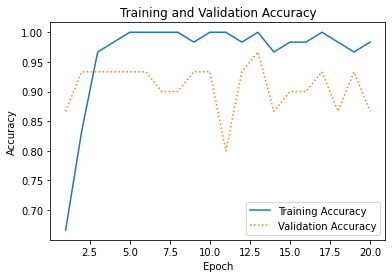

In [9]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Is the validation accuracy higher than that of the CNN built from scratch in the previous exercise? How did the training time compare?

## Make a prediction

What happens if the network is used to classify an image that it hasn't seen before? And how do you go about making such a prediction? Let's take a hot-dog image and see how the network classifies it. The first step is to load the image.

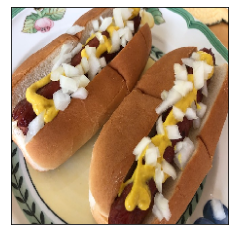

In [10]:
from keras.preprocessing import image

x = image.load_img('food/samples/hot-dog.jpg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Next, we preprocess the image and run it through `ResNet50V2`'s feature-extraction layers, and then run the output through our newly trained classification layers.

In [11]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255 # Divide by 255 to rescale the image the same way ImageDataGenerator did

# Make a prediction
y = base_model.predict(x)
predictions = model.predict(y)
print(predictions[0])

[1. 0. 0.]


The model predicts with a high degree of certainty that the image contains an example of class 0. But what is class 0? We can get a dictionary of class names and 0-based class indices from `ImageDataGenerator`'s `class_indices` attribute, and then use it to correlate probabilities to class labels such as "hotdog" and "pizza." Here's how the model scored the image for all three classes.

In [12]:
def show_labeled_probs(prediction, indices):
    for i in range(prediction.size):
        label = list(indices.keys())[list(indices.values()).index(i)]
        print(label + ': ' + str(prediction[i]))

show_labeled_probs(predictions[0], class_indices)

hotdog: 1.0
pizza: 0.0
sushi: 0.0


Now let's try it with a sushi image. Start by loading the image.

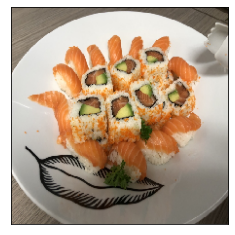

In [13]:
x = image.load_img('food/samples/sushi.jpg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Preprocess the image and make a prediction.

In [14]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255

y = base_model.predict(x)
predictions = model.predict(y)
print(predictions[0])

show_labeled_probs(predictions[0], class_indices)

[0.000000e+00 5.416041e-23 1.000000e+00]
hotdog: 0.0
pizza: 5.416041e-23
sushi: 1.0


`ResNet50V2` wasn't trained to recognize sushi in images, but our network was.